In [1]:
import os
import sys
from pathlib import Path

import numpy as np
import pandas as pd
from cycler import cycler
import matplotlib.pyplot as plt
import matplotlib as mpl; mpl.set_loglevel('error')

if str(Path.cwd().parent) not in sys.path:
    sys.path.append(str(Path.cwd().parent))

from settings.paths import img_path, rf_path, bmdn_path, flex_path, validation_path
from utils.metrics import rmse, out_frac, nmad, bias

%load_ext autoreload
%autoreload 2

blue = (0, 0.48, 0.70)
orange = (230/255, 159/255, 0)
yellow = (0.94, 0.89, 0.26)
pink = (0.8, 0.47, 0.65)
CB_color_cycle = ['#377eb8', '#ff7f00', '#4daf4a', '#f781bf', '#a65628', '#984ea3', '#999999', '#e41a1c', '#dede00']
plt.rcParams['axes.prop_cycle'] = cycler('color', CB_color_cycle)

In [2]:
list_feat = ["broad", "broad+narrow", "broad+GALEX+WISE", "broad+GALEX+WISE+narrow"]
list_color = ["#377eb8", "#ff7f00", "#4daf4a", "#f781bf"]
color_feat = dict(zip(list_feat, list_color))

In [3]:
z = {}
for feat in list_feat:
    print(feat)
    # if "GALEX" and "WISE" in feat:
    #     z[feat] = pd.read_csv(os.path.join(rf_path, "val_z_"+feat+"+flags.csv"), index_col=0)
    # else:
    z[feat] = pd.read_csv(os.path.join(rf_path, "val_z_"+feat+".csv"), index_col=0)

broad
broad+narrow
broad+GALEX+WISE
broad+GALEX+WISE+narrow


# Figure 4

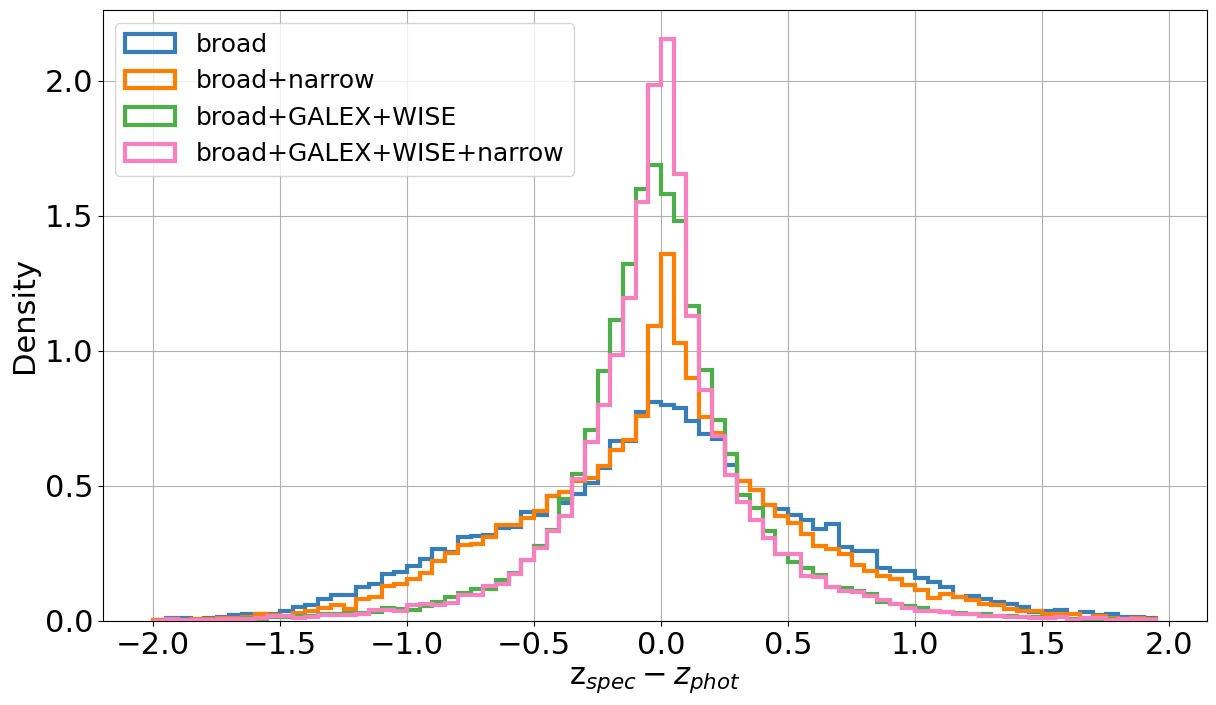

In [4]:
plt.figure(figsize=(12,7))
bins = np.arange(-2, 2, 0.05)
for key, model in z.items():
    plt.hist(z[key].Z - z[key].z_pred, bins=bins, zorder=10, alpha=1, histtype="step",
             linewidth=3, label=key, density=True)
plt.grid(zorder=0)
plt.ylabel("Density", size=22)
plt.xlabel(r"z$_{spec}-z_{phot}$", size=22)
plt.legend(fontsize=18, loc="upper left")
plt.tight_layout()
plt.tick_params(axis='both', which='major', labelsize=22)
plt.savefig(os.path.join(img_path, "residuals_all.png"))
plt.savefig(os.path.join(img_path, "residuals_all.eps"), format='eps')

# plt.ylim(0, 2.2)
plt.show()

# Figure 5

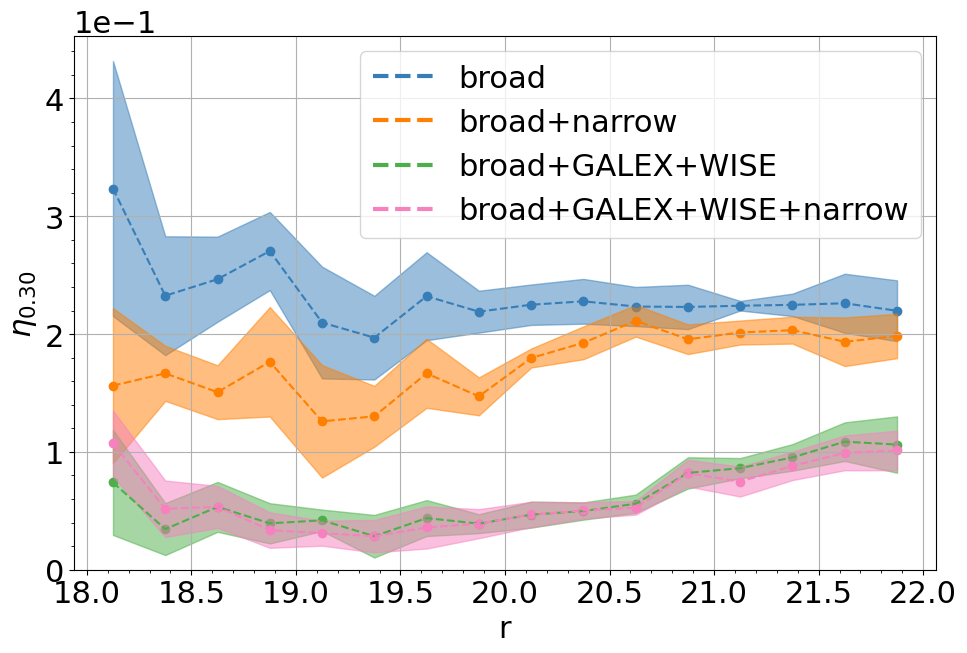

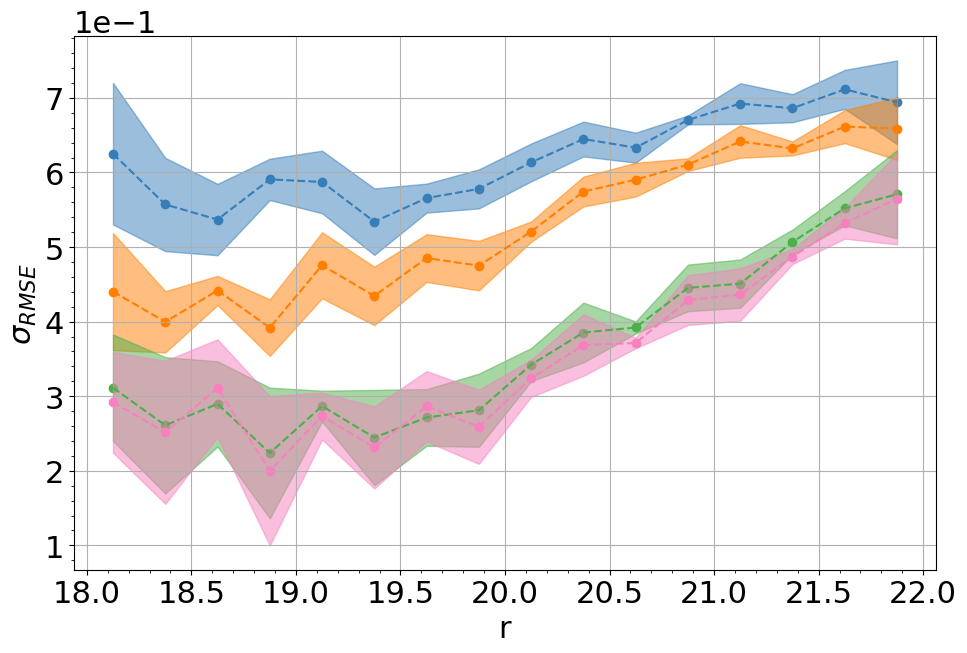

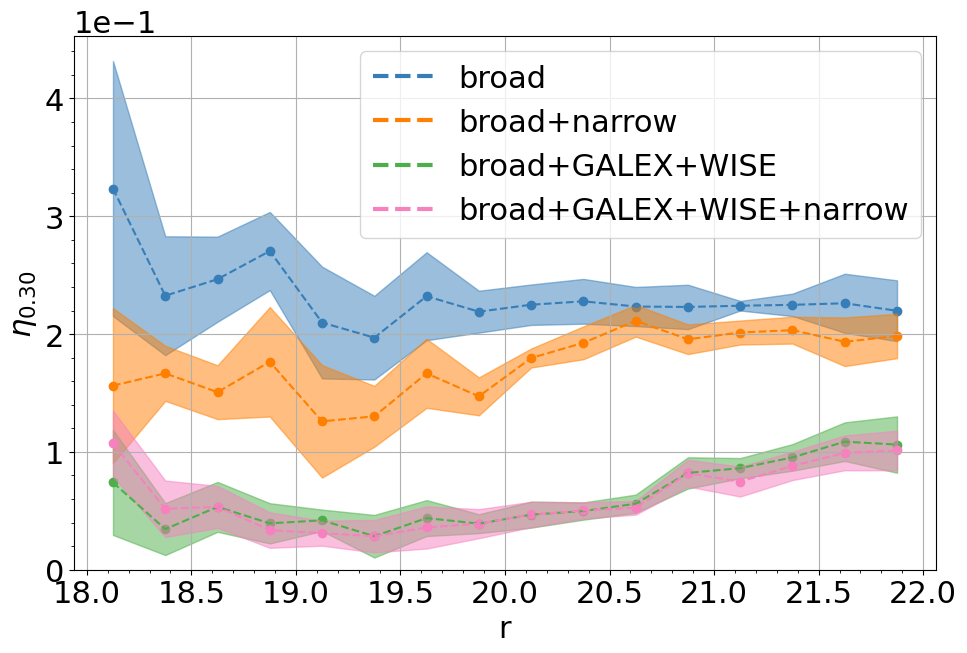

In [5]:
from utils.plots import plot_metric_per_bin

std = True
bins = np.arange(18, 22.2, 0.25)
plot_metric_per_bin(list_feat, z, rmse, color_feat=color_feat, std=std, bins=bins, save=True, legend=False)
plot_metric_per_bin(list_feat, z, out_frac, color_feat=color_feat, std=std, bins=bins, save=True, legend=True)


# Figures 6 and 7

In [6]:
from utils.plots import plot_PDFs

In [7]:
aux_path = os.path.join(bmdn_path, 'crossval_model_dr4_BNWG_700e')
sdss = pd.read_csv(os.path.join(aux_path, 'Results_DF.csv'), usecols=['SDSS_NAME'])
z = pd.read_csv(os.path.join(aux_path, 'Results_DF.csv'), usecols=['z'])

x_bmdn = np.genfromtxt(os.path.join(aux_path, 'x.txt'))
x_flex = pd.read_csv(os.path.join(flex_path, 'z_grid.csv'), usecols=['x']).x.values

bmdn_models = {
    'Without narrow bands': pd.read_csv(os.path.join(bmdn_path, 'crossval_model_dr4_BWG_700e', 'Results_DF.csv')),
    'With narrow bands': pd.read_csv(os.path.join(bmdn_path, 'crossval_model_dr4_BNWG_700e', 'Results_DF.csv'))
}
flex_models = {
    'Without narrow bands': pd.read_csv(os.path.join(flex_path, 'test_z_broad+GALEX+WISE.csv')),
    'With narrow bands': pd.read_csv(os.path.join(flex_path, 'test_z_broad+GALEX+WISE+narrow.csv'))
    }
colors_dict = {
    'Without narrow bands': color_feat["broad+GALEX+WISE"],
    'With narrow bands': color_feat["broad+GALEX+WISE+narrow"]
    }

idxs = np.array([
    [133, 6364, 2293],
    [7185, 3231, 977],
    [4626, 3653, 7995]
])

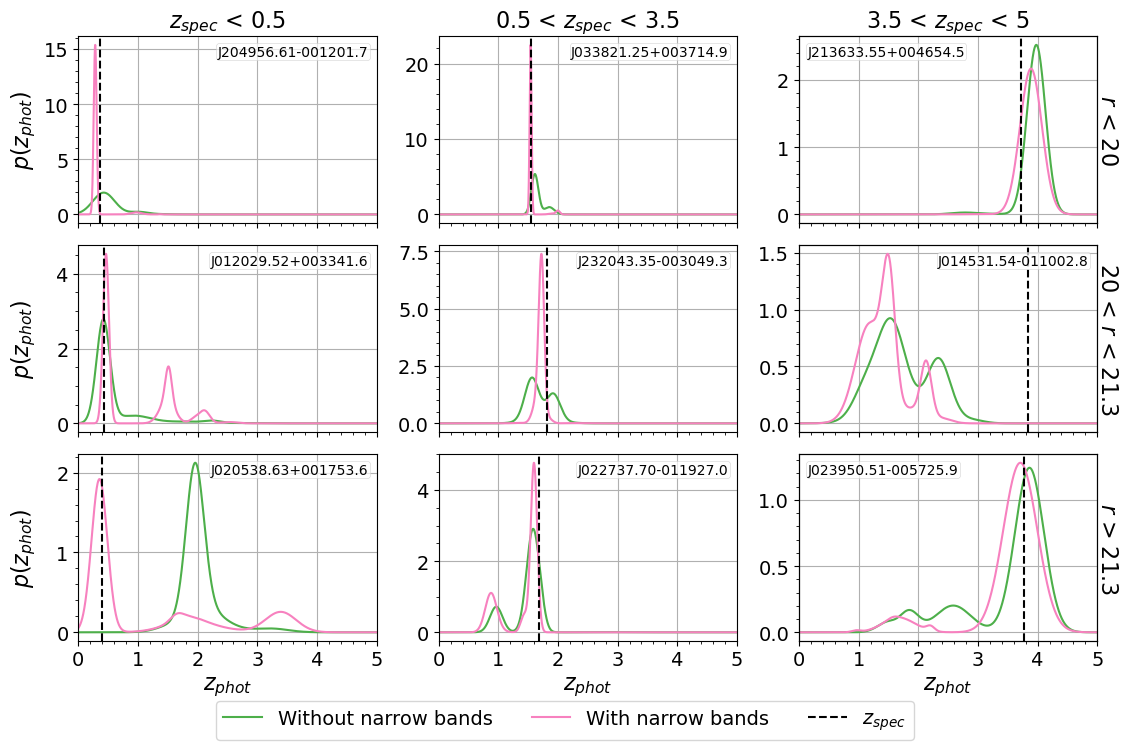

In [8]:
plot_PDFs('BMDN', bmdn_models, sdss, z, x_bmdn, idxs, colors_dict, save=True)

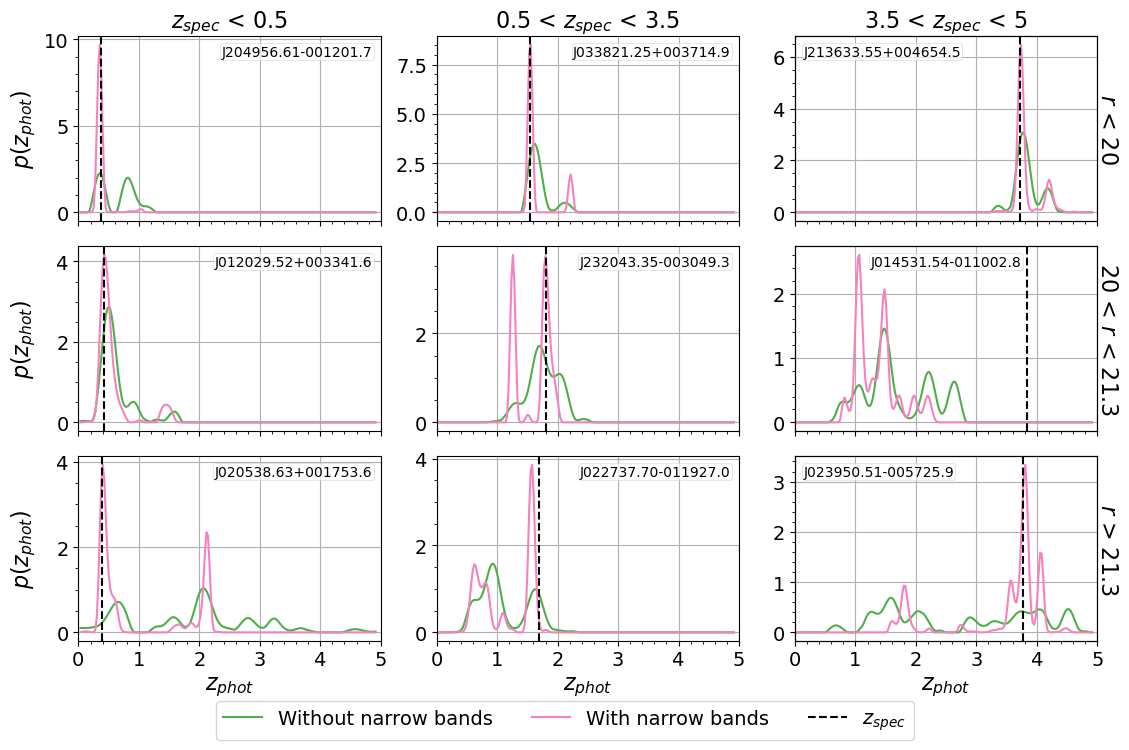

In [9]:
plot_PDFs('FlexCoDE', flex_models, sdss, z, x_flex, idxs, colors_dict, save=True)

# Figure 1 (Appendix)

In [10]:
from utils.plots import metric_per_bin, create_bins

In [11]:
z_results = pd.DataFrame()
test = pd.read_table(os.path.join(validation_path, "test.csv"), sep=",")
z_results["z_rf"] = pd.read_csv(os.path.join(rf_path, "test_z_broad+GALEX+WISE+narrow.csv")).z_pred
z_results["z_bmdn"] = pd.read_csv(os.path.join(bmdn_path, "crossval_model_dr4_BNWG_700e", "Results_DF.csv")).zphot
z_results["z_flex"] = pd.read_csv(os.path.join(flex_path, "test_z_broad+GALEX+WISE+narrow.csv")).z_flex_peak
z_results["z_mean"] = (z_results["z_rf"]+z_results["z_bmdn"]+z_results["z_flex"]) / 3

z_results["Z"] = test.Z
z_results["r_PStotal"] = test.r_PStotal
z_results["g_PStotal"] = test.g_PStotal
z_results["g-r"] = test.g_PStotal-test.r_PStotal


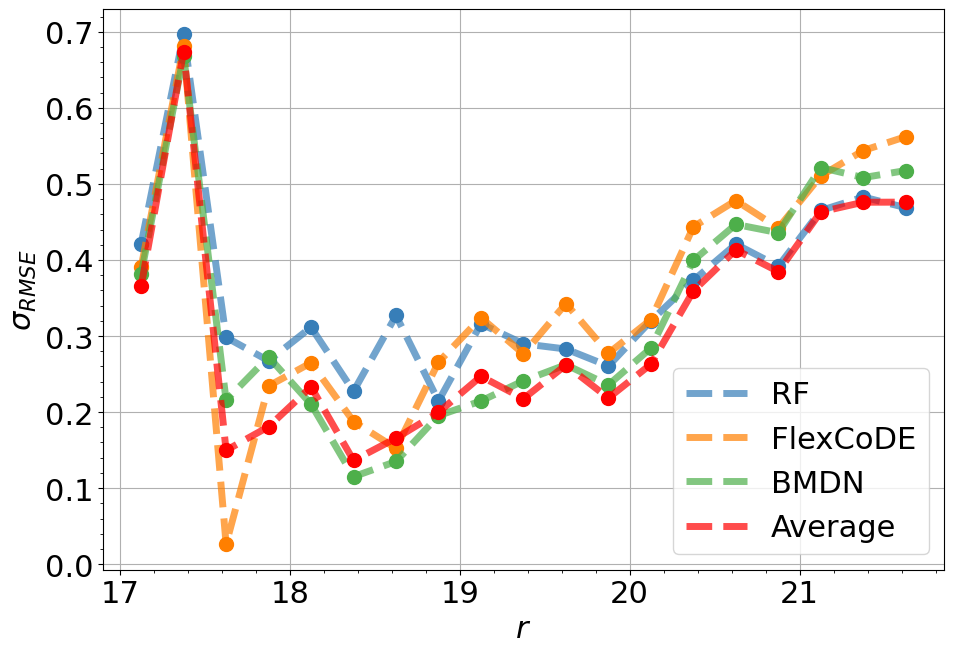

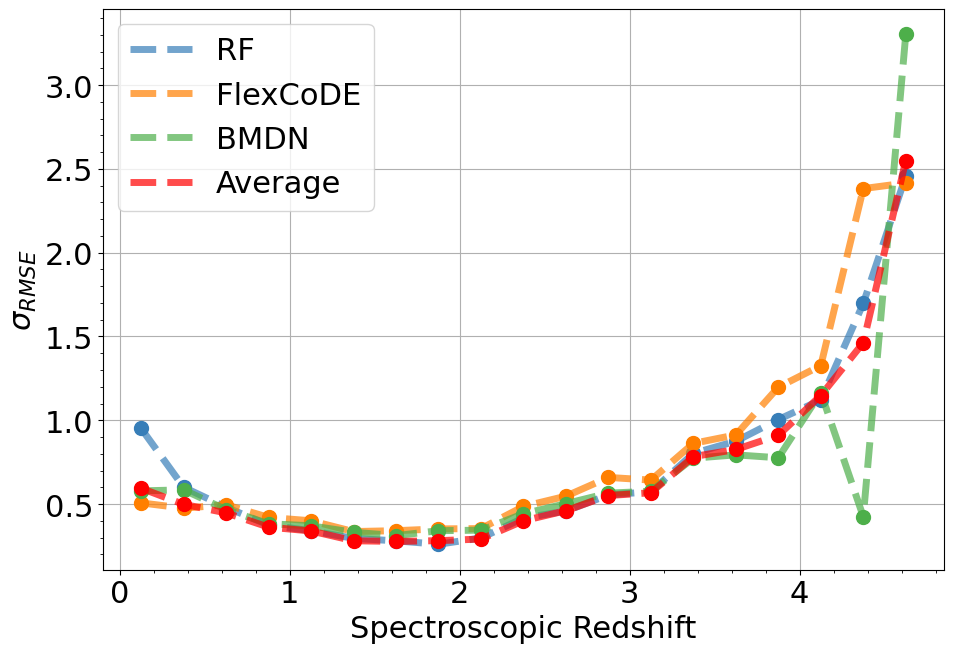

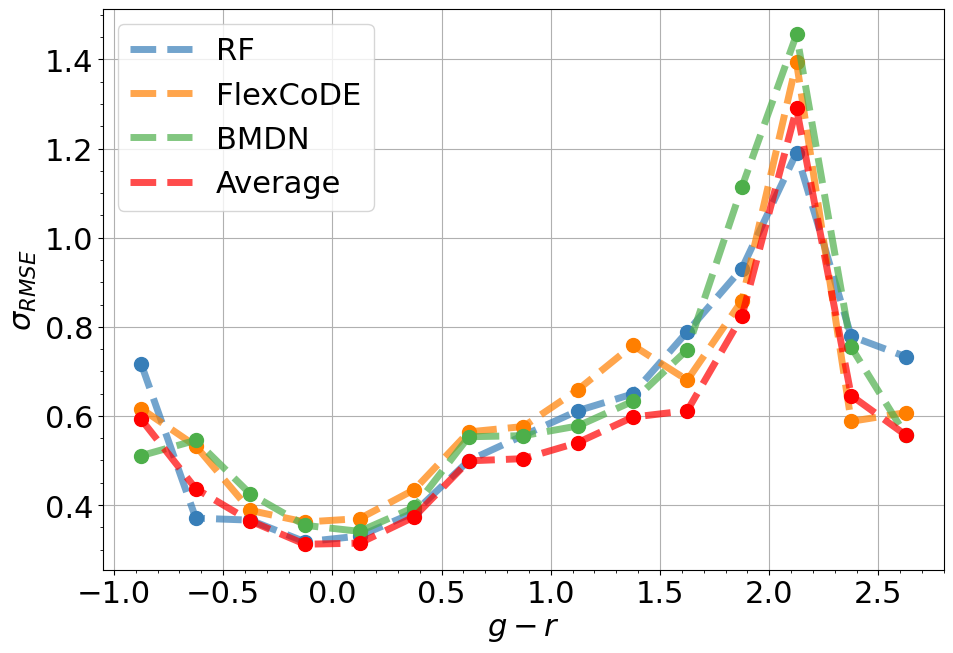

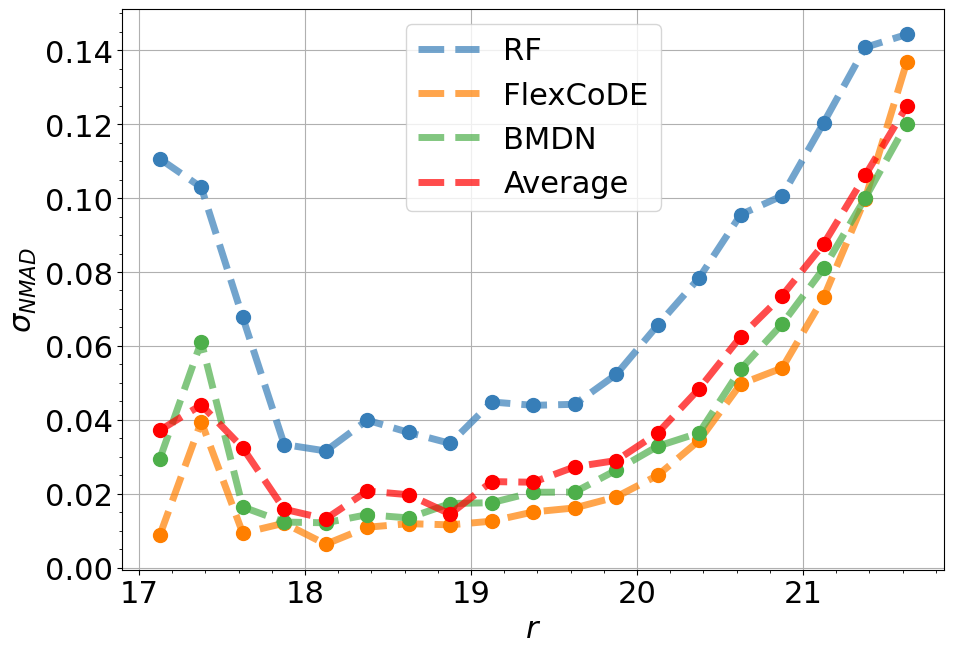

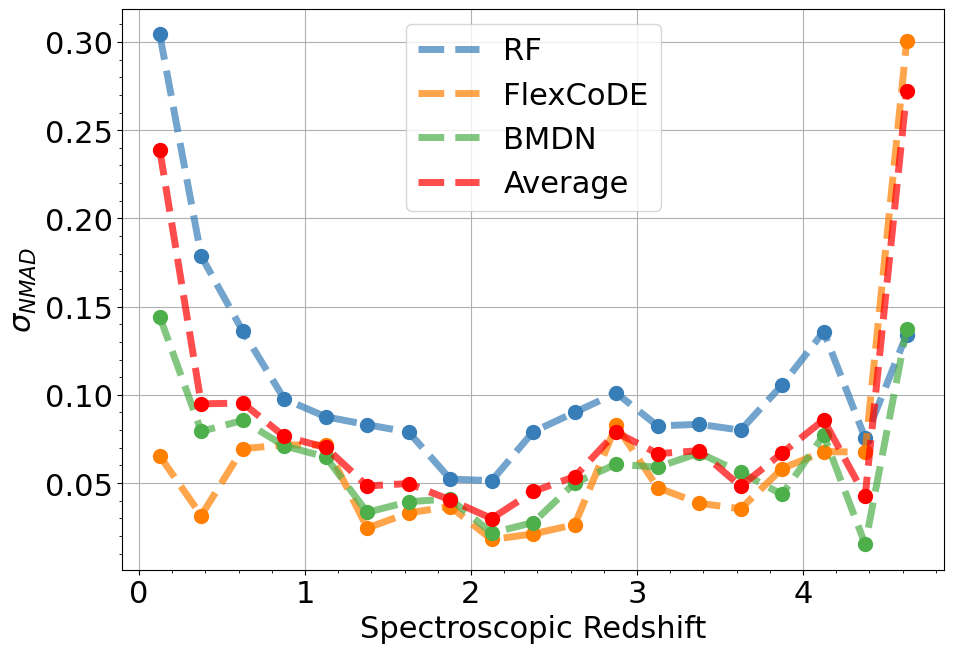

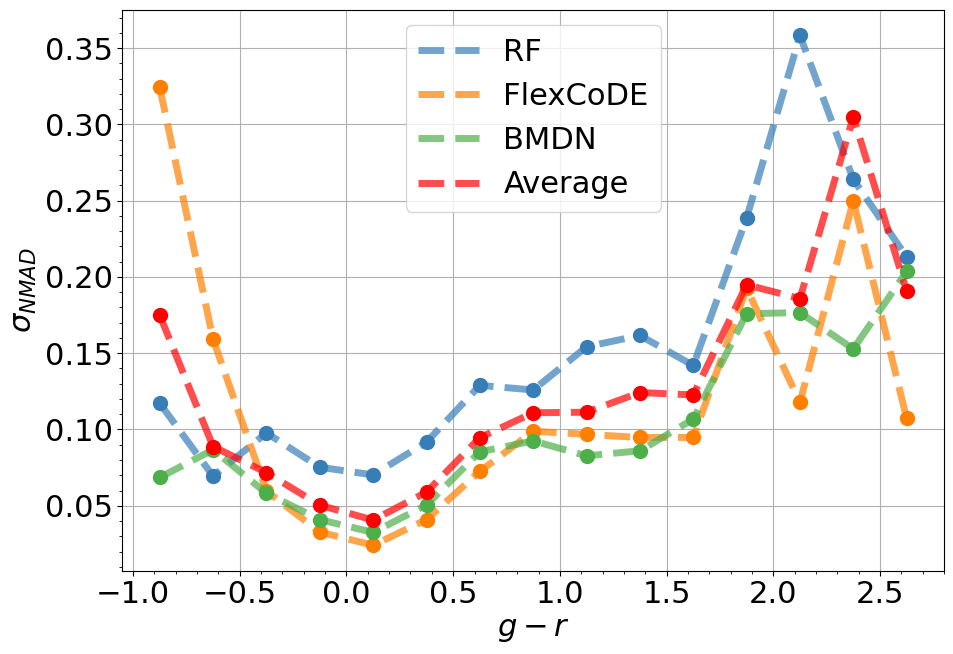

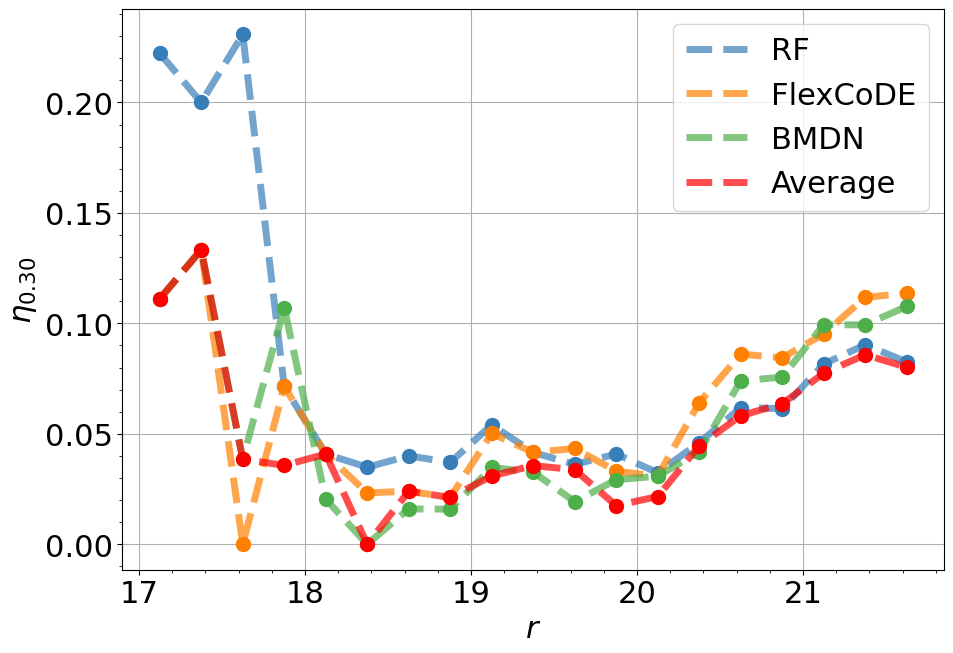

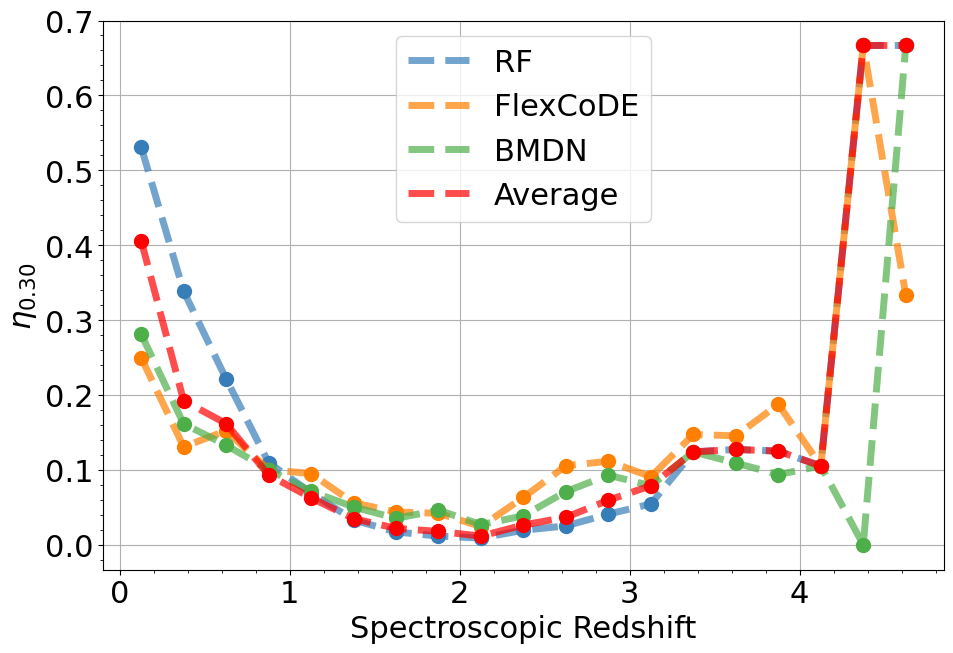

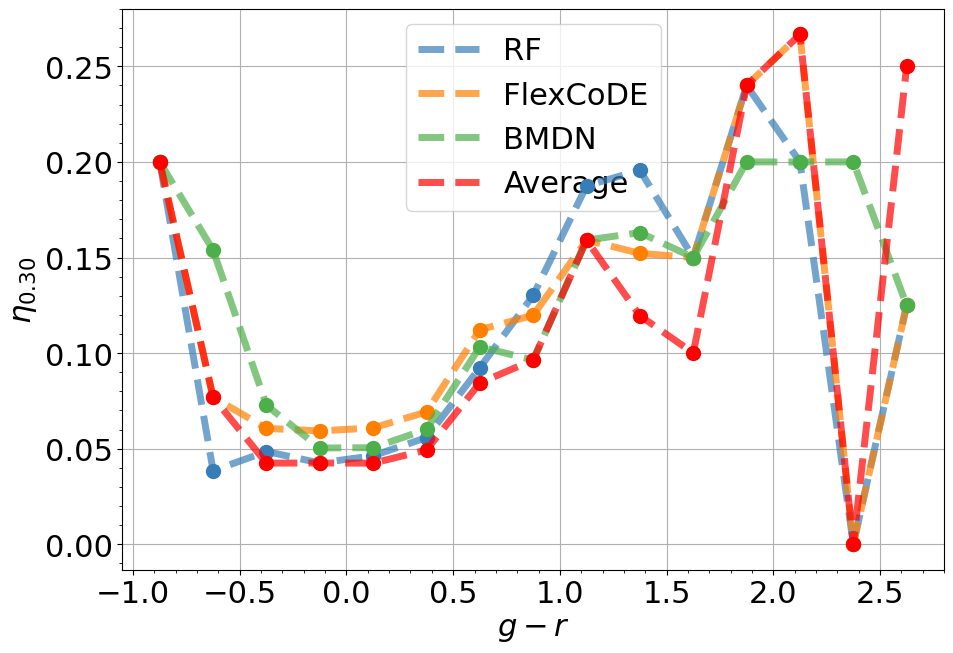

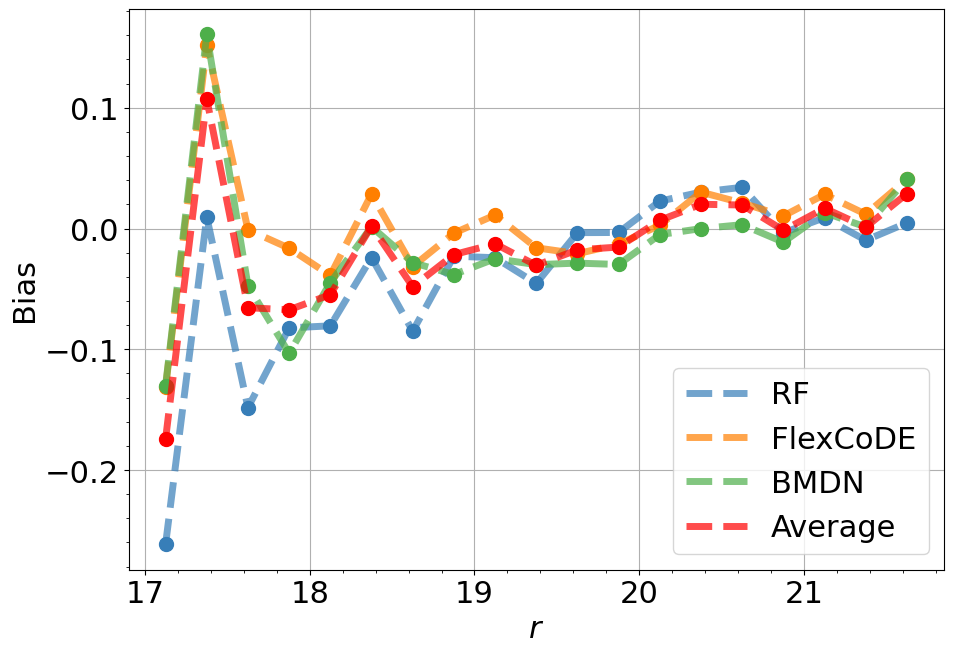

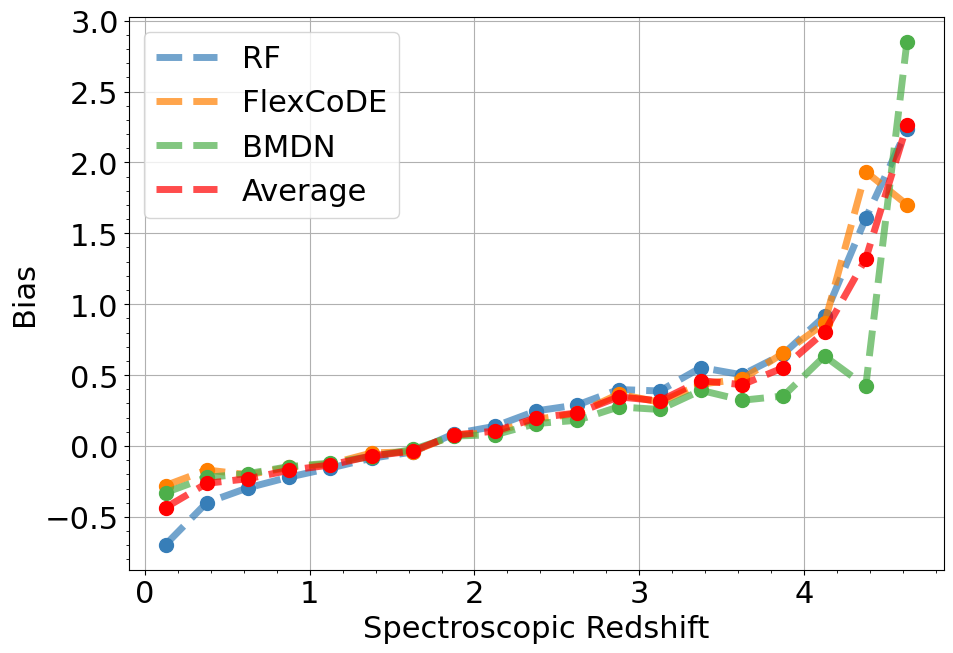

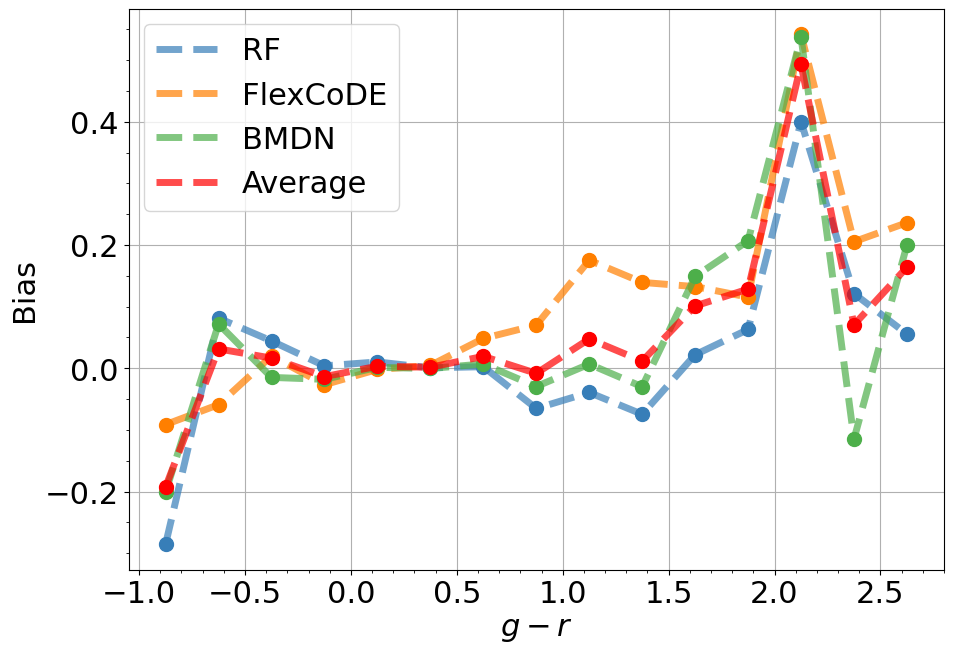

In [12]:
list_metric = [rmse, nmad, out_frac, bias]
list_var = ["r_PStotal", "Z", "g-r"]
z_no99 = z_results.query("r_PStotal!=99 and g_PStotal!=99")

df_output = {}
for metric in list_metric:
    for var in list_var:
        if var == "r_PStotal":
            bins = np.arange(17, 22, 0.25)
        elif var =="Z":
            bins = np.arange(0, 5, 0.25)
        else:
            bins = np.arange(-1., 3, 0.25)

        bins_r, itv_r = create_bins(z_no99, return_data=False, var=var, bins=bins)
        bin_size = bins_r[1] - bins_r[0]
        half_bins = np.arange(bins_r[0] + bin_size/2, bins_r[-1] + bin_size/2, bin_size)
        output_rf = metric_per_bin(metric=metric, z=z_no99, itvs=itv_r, column="z_rf")
        output_bmdn = metric_per_bin(metric=metric, z=z_no99, itvs=itv_r, column="z_bmdn")
        output_flex = metric_per_bin(metric=metric, z=z_no99, itvs=itv_r, column="z_flex")
        output_mean = metric_per_bin(metric=metric, z=z_no99, itvs=itv_r, column="z_mean")
        key = metric.__name__+"_"+var
        df_output[key] = pd.DataFrame([output_rf, output_bmdn, output_flex, output_mean, half_bins])
        df_output[key] = df_output[key].T
        df_output[key].columns = ["rf", "bmdn", "flex", "mean", "bins"]
        df_output[key]["rf_norm"] = df_output[key]["rf"]
        df_output[key]["bmdn_norm"] = df_output[key]["bmdn"]
        df_output[key]["flex_norm"] = df_output[key]["flex"]
        fig, ax = plt.subplots(1, 1, figsize=(10,7))
        s = 100
        ax.scatter(half_bins,df_output[key]["rf_norm"], s=s, zorder=1000)
        ax.plot(half_bins,df_output[key]["rf_norm"], '--', label="RF", linewidth=5, alpha=0.7, zorder=1000)
        ax.scatter(half_bins,df_output[key]["flex_norm"], s=s, zorder=1000)
        ax.plot(half_bins,df_output[key]["flex_norm"], '--', label="FlexCoDE", linewidth=5, alpha=0.7, zorder=1000)
        ax.scatter(half_bins,df_output[key]["bmdn_norm"], s=s, zorder=1000)
        ax.plot(half_bins,df_output[key]["bmdn_norm"], '--', label="BMDN", linewidth=5, alpha=0.7, zorder=1000)
        ax.scatter(half_bins,output_mean, s=s, zorder=1000, color="red")
        ax.plot(half_bins,output_mean, '--', label="Average", linewidth=5, alpha=0.7, zorder=1000, color="red")

       
        if metric.__name__ == "rmse":
            ax.set_ylabel(r"$\sigma_{RMSE}$")
        elif metric.__name__ == "out_frac":
            ax.set_ylabel(r"$\eta_{0.30}$")
        elif metric.__name__ == "bias":
            ax.set_ylabel("Bias")
        elif metric.__name__ == "mse":
            ax.set_ylabel("MSE")
        else:
            ax.set_ylabel(r"$\sigma_{NMAD}$")   

        if var == "r_PStotal":
            ax.set_xlabel(r"$r$")
        elif var =="Z":
            ax.set_xlabel("Spectroscopic Redshift")
        else:
            ax.set_xlabel(r"$g-r$")    
        plt.grid()
        plt.legend()
        plt.tight_layout()
        plt.savefig(os.path.join(img_path, metric.__name__+"_"+var+"_allmodels.png"))
        plt.savefig(os.path.join(img_path, metric.__name__+"_"+var+"_allmodels.eps"), format="eps")
        # plt.show()